In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn import model_selection
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split


# Import the Data

In [76]:
heart_file_path = "/Users/anna-alexandradanchenko/Documents/University/Second Year/Data Science/HeartAttackAnalysis/input/heart.csv"
o2_file_path = "/Users/anna-alexandradanchenko/Documents/University/Second Year/Data Science/HeartAttackAnalysis/input/o2Saturation.csv"

df_data = pd.read_csv(heart_file_path)

df_o2 = pd.read_csv(o2_file_path)
df_o2 = df_o2.rename(columns={"98.6": "satlvl"})

df_data["satlvl"] = df_o2["satlvl"]
df_data = df_data.rename(columns={"thalachh": "max_heart_rate", "fbs": "fasting_blsugar", "trtbps": "rest_blpressure"})
df_data.head(10)

,age,sex,cp,rest_blpressure,chol,fasting_blsugar,restecg,max_heart_rate,exng,oldpeak,slp,caa,thall,output,satlvl
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1,98.6
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1,98.6
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1,98.6
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1,98.1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1,97.5
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1,97.5
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1,97.5
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1,97.5
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1,97.5
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1,97.5


# Handling Missing Data
As can be seen from the code below, there are no missing data and only one duplicate, therefore we can conclude that the data is already clean.

In [77]:
count_nan_in_df = df_data.isnull().sum()
print(count_nan_in_df)

count_duplicates = df_data.duplicated().value_counts()
print(count_duplicates)

column_to_move = 'output'
new_order = [col for col in df_data.columns if col != column_to_move] + [column_to_move]
df_data = df_data[new_order]


age                0
sex                0
cp                 0
rest_blpressure    0
chol               0
fasting_blsugar    0
restecg            0
max_heart_rate     0
exng               0
oldpeak            0
slp                0
caa                0
thall              0
output             0
satlvl             0
dtype: int64
False    302
True       1
Name: count, dtype: int64


# Correlation Evaluation and Feature Selection 
## Correlation of Variables with Output

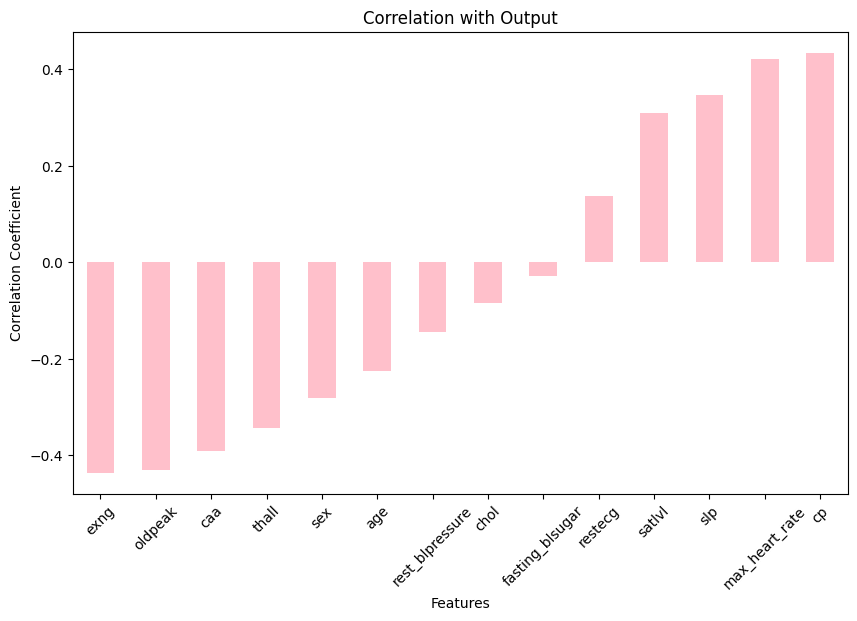

In [78]:
data_corr = df_data.corr()['output'][:-1].sort_values() # -1 means that the latest row is SalePrice
# top_features = data_corr[abs(data_corr) > 0.2].sort_values(ascending=False) #displays pearsons correlation coefficient greater than 0.2
# print("There is {} strongly correlated values with SalePrice:\n{}".format(len(top_features), top_features))

plt.figure(figsize=(10, 6))
data_corr.plot(kind='bar', color='pink')
plt.title('Correlation with Output')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.show()

## Correlation Matrix Heatmap

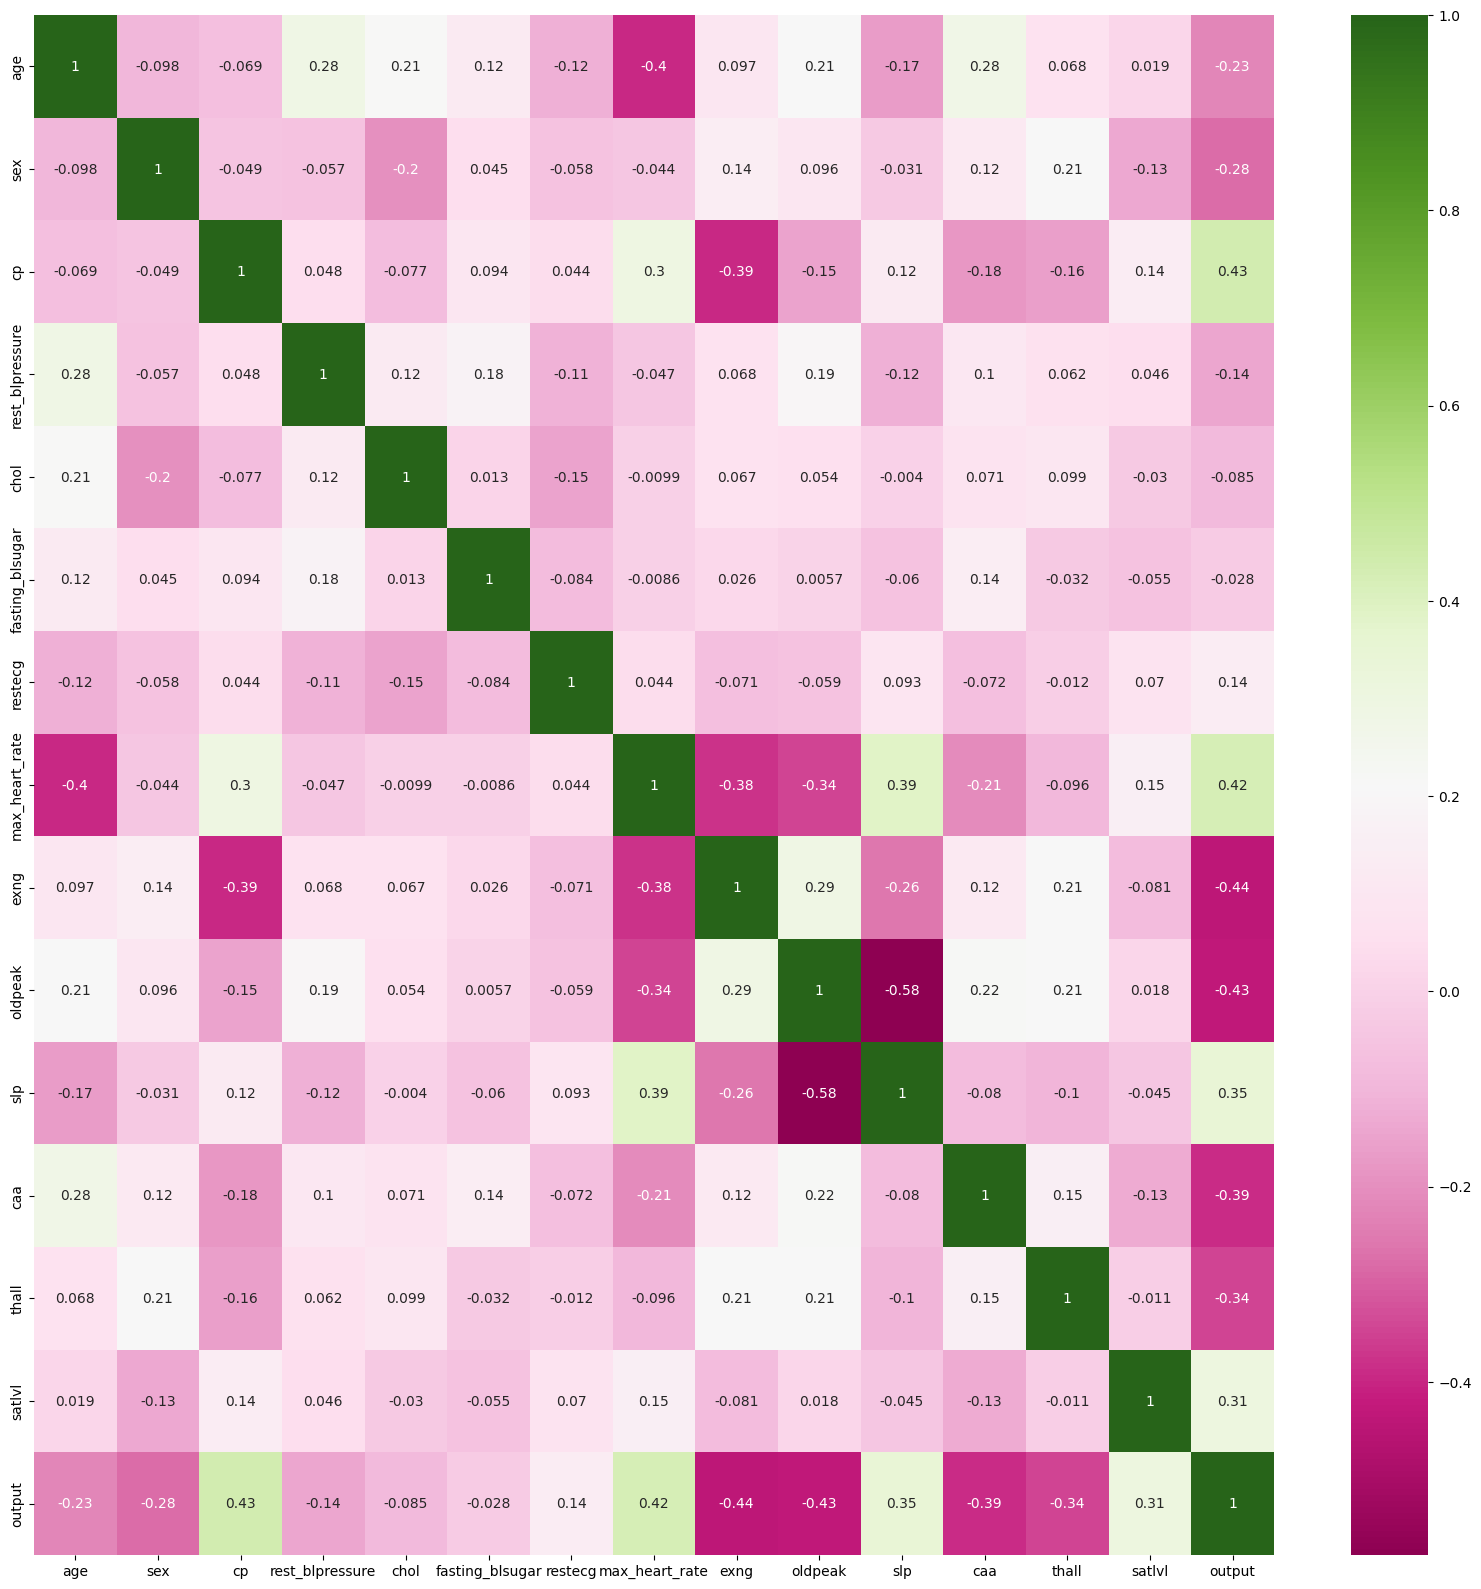

In [79]:
corrMatrix = df_data.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corrMatrix, annot=True, cmap="PiYG")
plt.show()

## Recursive Feature Selection

Optimal number of features: 14


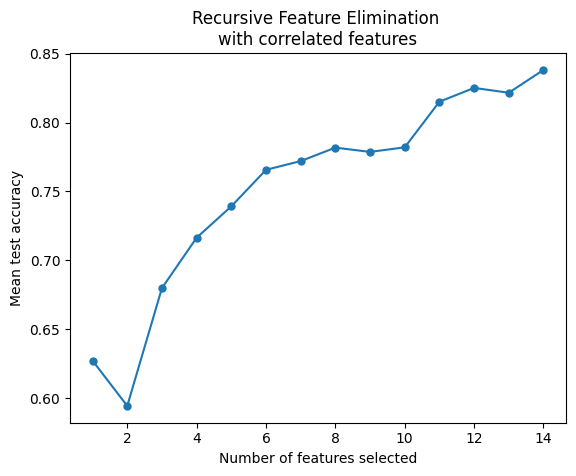

In [80]:
X = df_data.drop("output", axis=1)
y = df_data["output"]

model = RandomForestClassifier(n_estimators=100, random_state=0)

rfecv = RFECV(
    estimator=model,
    scoring="accuracy",
    n_jobs=2,
)

rfecv.fit(X, y)
print(f"Optimal number of features: {rfecv.n_features_}")

n_scores = len(rfecv.cv_results_["mean_test_score"])

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(1, n_scores + 1),
    rfecv.cv_results_["mean_test_score"],
    marker='o', 
    markersize=5
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

# Variables Distribution

age                 41
sex                  2
cp                   4
rest_blpressure     49
chol               152
fasting_blsugar      2
restecg              3
max_heart_rate      91
exng                 2
oldpeak             40
slp                  3
caa                  5
thall                4
satlvl               7
output               2
dtype: int64
The following columns are low cardinality columns: ['sex', 'cp', 'fasting_blsugar', 'restecg', 'exng', 'slp', 'caa', 'thall', 'satlvl', 'output']


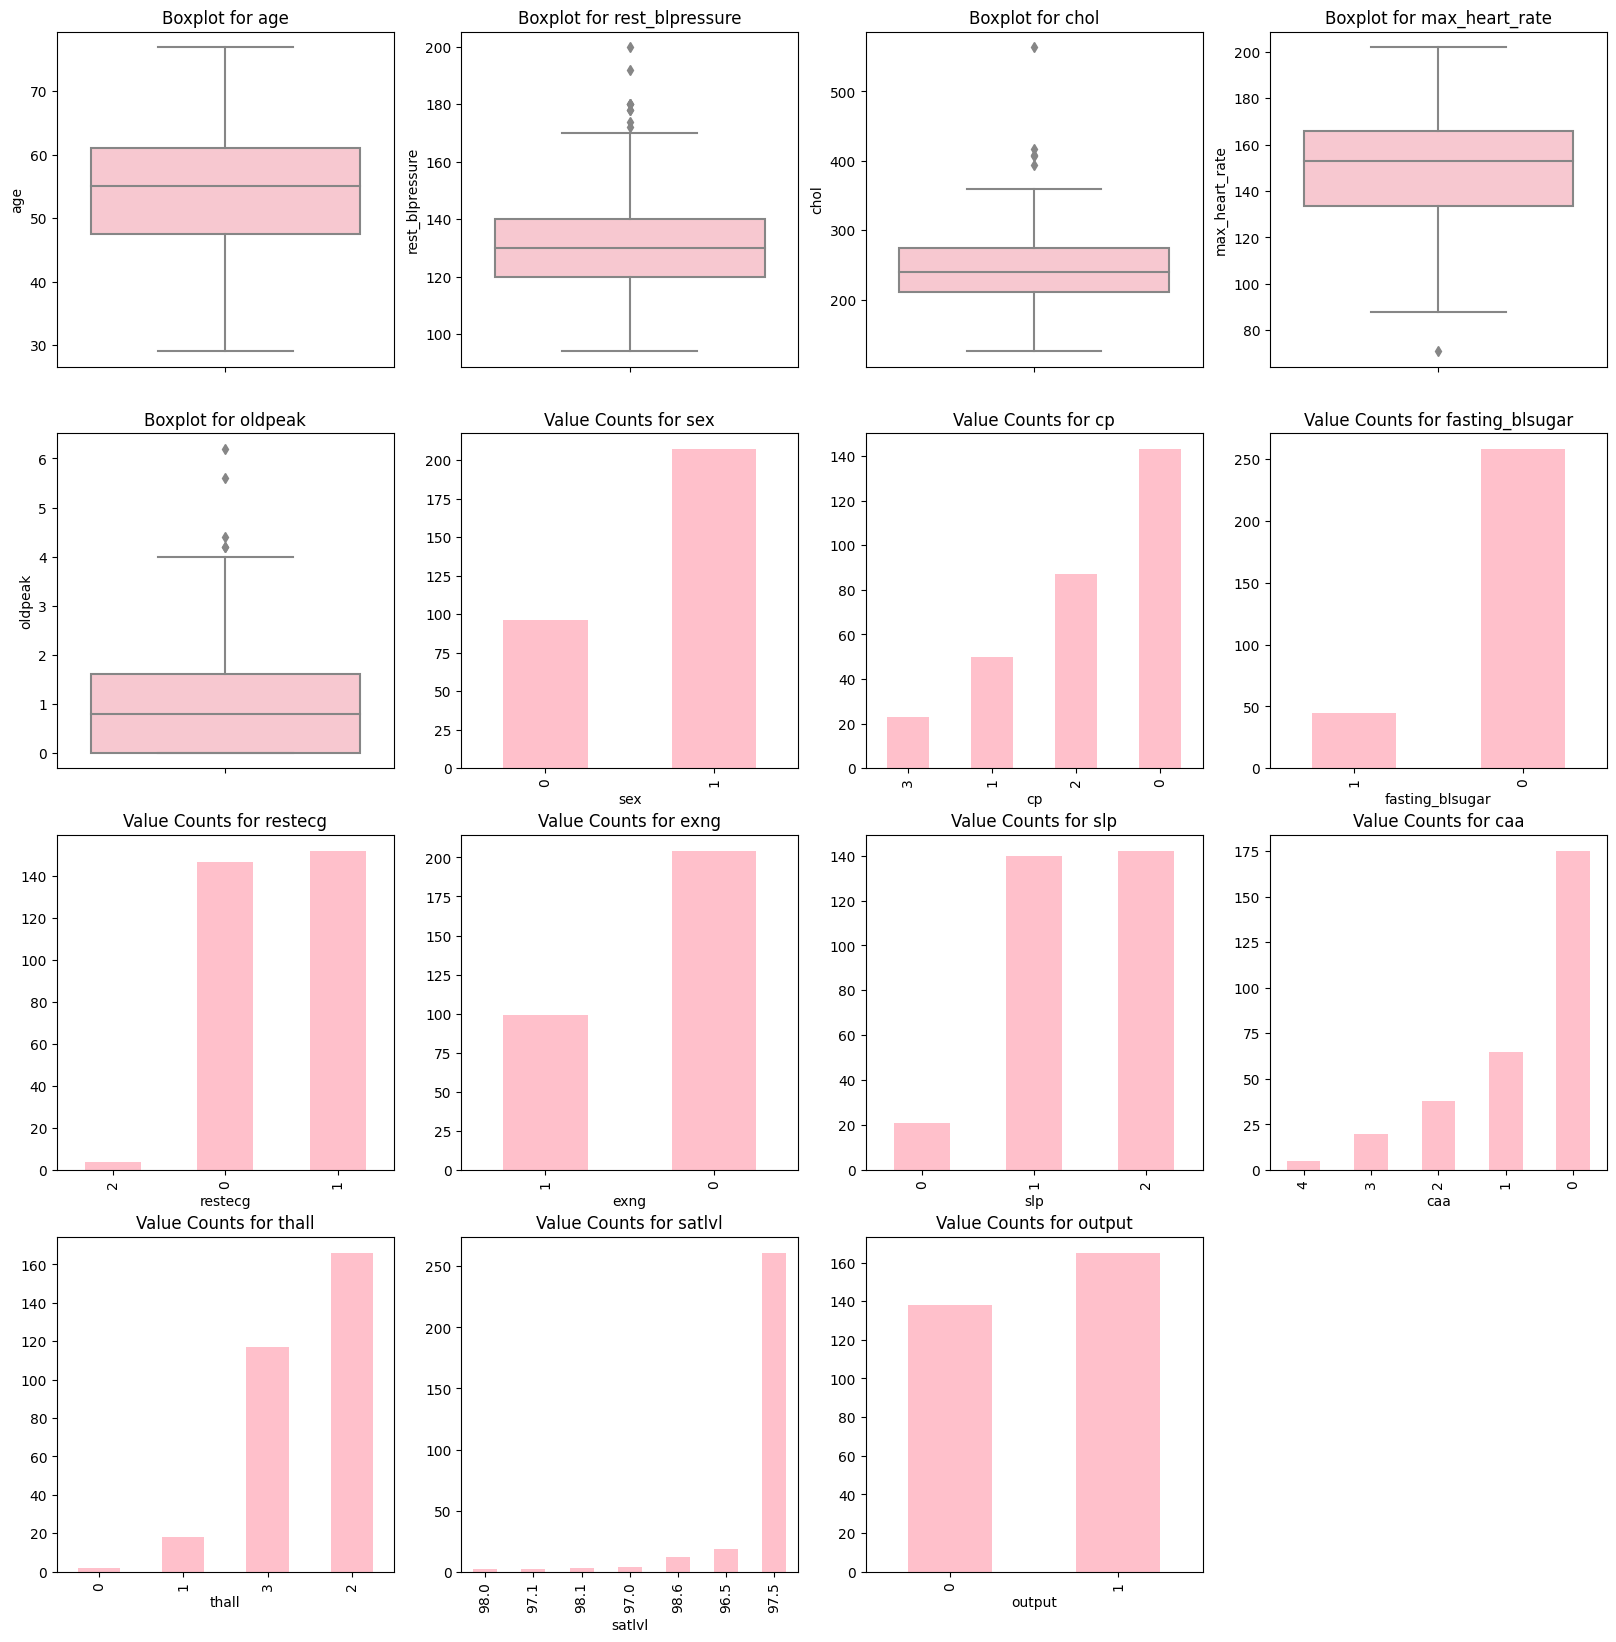

In [81]:
nunique_cnt = df_data.nunique()
print(nunique_cnt)

low_card_cols = nunique_cnt[nunique_cnt < 15].index.tolist()
high_card_cols = nunique_cnt[nunique_cnt >= 15].index.tolist()
print("The following columns are low cardinality columns: " + str(low_card_cols))

# Determine the total number of plots
total_plots = len(high_card_cols) + len(low_card_cols)

# Determine the number of rows and columns on the grid. It outputs integer, as it the numbers should be equal. 
# We choose a square grid that can fit all plots, or a rectangular one that's as close to square as possible
grid_size = int(np.ceil(np.sqrt(total_plots)))
# Create a figure with the grid layout
plt.figure(figsize=(20, 20))

# Plotting high cardinality columns
for i, column in enumerate(high_card_cols):
    plt.subplot(grid_size, grid_size, i + 1)
    sns.boxplot(y=df_data[column], color="pink")
    plt.title(f'Boxplot for {column}')

# Plotting low cardinality columns
for i, column in enumerate(low_card_cols):
    plt.subplot(grid_size, grid_size, i + len(high_card_cols) + 1)
    column_value_counts = df_data[column].value_counts().sort_values()
    column_value_counts.plot(kind='bar', color='pink')
    plt.title(f'Value Counts for {column}')

# Values Encoding and Data Preparation

In [82]:
low_card_cols.remove("satlvl")
low_card_cols.remove("output")

encoded_data = pd.get_dummies(df_data[low_card_cols], columns = low_card_cols, drop_first=False)
encoded_data = encoded_data.astype(int)

df_data.drop(low_card_cols, axis = 1, inplace = True)
df_data = pd.concat([df_data, encoded_data], axis = 1)

df_data.head()

,age,rest_blpressure,chol,max_heart_rate,oldpeak,satlvl,output,sex_0,sex_1,cp_0,...,slp_2,caa_0,caa_1,caa_2,caa_3,caa_4,thall_0,thall_1,thall_2,thall_3
0,63,145,233,150,2.3,98.6,1,0,1,0,...,0,1,0,0,0,0,0,1,0,0
1,37,130,250,187,3.5,98.6,1,0,1,0,...,0,1,0,0,0,0,0,0,1,0
2,41,130,204,172,1.4,98.6,1,1,0,0,...,1,1,0,0,0,0,0,0,1,0
3,56,120,236,178,0.8,98.1,1,0,1,0,...,1,1,0,0,0,0,0,0,1,0
4,57,120,354,163,0.6,97.5,1,1,0,1,...,1,1,0,0,0,0,0,0,1,0


In [83]:
X = df_data.drop("output", axis = 1)
y = df_data["output"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

# Model Development

Compare the performance of different models. 

In [85]:
models = []
models.append(('LR', LogisticRegression(max_iter=3000)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('RFC', RandomForestClassifier()))
models.append(('NB', GaussianNB()))

# Dictionary comprehension 
model_scores = {name: {'Accuracy': [], 'Precision': [], 'Recall': [], 'F1': []} for name, model in models}

# Perform cross-validation
kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models:
    for train_index, test_index in kfold.split(X_train):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_test_fold)

        model_scores[name]['Accuracy'].append(accuracy_score(y_test_fold, y_pred))
        model_scores[name]['Precision'].append(precision_score(y_test_fold, y_pred, zero_division=0))
        model_scores[name]['Recall'].append(recall_score(y_test_fold, y_pred, zero_division=0))
        model_scores[name]['F1'].append(f1_score(y_test_fold, y_pred, zero_division=0))

# Print the average scores for each model
for name in model_scores:
    print(f"{name} Model:")
    for metric in model_scores[name]:
        average_score = np.mean(model_scores[name][metric])
        print(f"Average {metric}: {average_score:.3f}")


LR Model:
Average Accuracy: 0.863
Average Precision: 0.867
Average Recall: 0.884
Average F1: 0.874
KNN Model:
Average Accuracy: 0.816
Average Precision: 0.818
Average Recall: 0.860
Average F1: 0.837
RFC Model:
Average Accuracy: 0.825
Average Precision: 0.840
Average Recall: 0.847
Average F1: 0.839
NB Model:
Average Accuracy: 0.783
Average Precision: 0.803
Average Recall: 0.793
Average F1: 0.791


## Further Data Improvements

Normalize the data. After the data normalization, the performance scores of the Linear Regression Model and K Neighbors Classifier grew for 0.02 and 0.2 points accordingly, which is considered as improvement. 

In [84]:
scaler = MinMaxScaler(feature_range = (0,1))

scaler.fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_test_transformed = scaler.transform(X_test)

X_train = pd.DataFrame(X_train_transformed, columns = X_train.columns)
X_test = pd.DataFrame(X_test_transformed, columns = X_test.columns)

## Final Model Training

In [89]:
forest_model = LogisticRegression(max_iter = 3000, random_state = 42, n_jobs = -1)
forest_model.fit(X_train, y_train)
y_preds = forest_model.predict(X_test)

print(f'Accuracy Score : ' + str(accuracy_score(y_test,y_preds)))
print('Precision Score : ' + str(precision_score(y_test,y_preds)))
print('Recall Score : ' + str(recall_score(y_test,y_preds)))
print('F1 Score : ' + str(f1_score(y_test,y_preds)))

Accuracy Score : 0.8571428571428571
Precision Score : 0.8269230769230769
Recall Score : 0.9148936170212766
F1 Score : 0.8686868686868686


### Try Hyperparameter Tuning using Randomized Search

In [90]:
solver = ['lbfgs', 'newton-cg', 'liblinear']
warm_start = [True, False]
random_grid ={
    'warm_start' : warm_start,
    'solver' : solver
}

rf_random = RandomizedSearchCV(estimator = LogisticRegression(max_iter=5000), param_distributions = random_grid, n_iter = 100, cv = 3, verbose=1, n_jobs = -1)
rf_random.fit(X_train, y_train)

model_random = rf_random.best_estimator_
y_preds_best = model_random.predict(X_test)

print('Accuracy Score : ' + str(accuracy_score(y_test,y_preds_best)))
print('Precision Score : ' + str(precision_score(y_test,y_preds_best)))
print('Recall Score : ' + str(recall_score(y_test,y_preds_best)))
print('F1 Score : ' + str(f1_score(y_test,y_preds_best)))

Fitting 3 folds for each of 6 candidates, totalling 18 fits


/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=100. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Accuracy Score : 0.8571428571428571
Precision Score : 0.8269230769230769
Recall Score : 0.9148936170212766
F1 Score : 0.8686868686868686


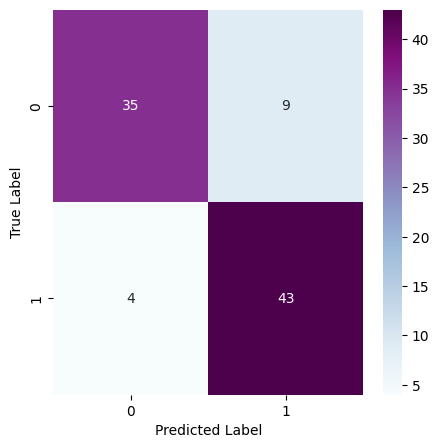

In [91]:
confMat = confusion_matrix(y_test,y_preds)
plt.figure(figsize=(5, 5))

sns.heatmap(confMat, annot=True, cmap="BuPu")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.show()